In [ ]:
pip install llama-index-core llama-index-readers-file llama-index-llms-ollama llama-index-embeddings-huggingface

In [ ]:
pip install llama_index

In [ ]:
%pip install llama-index-embeddings-ollama

In [ ]:
pip install spacy

In [7]:
from llama_index.core import SimpleDirectoryReader

In [8]:
import nest_asyncio
import openai
import time

nest_asyncio.apply()

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext,
)
from llama_index.core.evaluation import ( DatasetGenerator, FaithfulnessEvaluator,  RelevancyEvaluator)
from llama_index.llms.openai import OpenAI



In [9]:
from llama_index.readers.file import (
    PandasCSVReader,
    CSVReader
)
# CSV Reader Llamaindex
parser = CSVReader()
file_extractor = {".csv": parser}  # Add other CSV formats as needed
documents = SimpleDirectoryReader(
    "./documenti", file_extractor=file_extractor
).load_data()

In [ ]:
documents

In [11]:
from llama_index.llms.ollama import Ollama

llama = Ollama(model="llama3.1", request_timeout=120.0)

In [12]:
from llama_index.embeddings.ollama import OllamaEmbedding

emb_ollama = OllamaEmbedding(model_name="nomic-embed-text")

In [ ]:
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator
# Per valutare le dimensioni di ciascun chunk, genereremo prima un insieme di 40 domande dalle prime 20 pagine..
eval_documents = documents[:20]
data_generator = DatasetGenerator.from_documents(documents, llm=llama)
eval_questions = data_generator.generate_questions_from_nodes(num = 20)


# Definire gli Evaluatori di Accuratezza e Rilevanza basati su LLAMA
faithfulness_llama = FaithfulnessEvaluator(llm=llama)
relevancy_llama = RelevancyEvaluator(llm=llama)


In [ ]:
eval_questions

### NUOVO METODO DELLA LIBRERIA

In [ ]:
from llama_index.core.llama_dataset.generator import RagDatasetGenerator , LabelledRagDataset
from llama_index.core import Settings
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator

# Supponendo che `documents` e `llama` siano già definiti

# Utilizzare le prime 20 pagine per la valutazione
eval_documents = documents[:20]

# Generare un set di 40 domande dalle prime 20 pagine utilizzando il nuovo RagDatasetGenerator
#data_generator = RagDatasetGenerator.from_documents(documents, llm=llama)
#eval_questions = data_generator.generate_questions_from_nodes(num=40)

dataset_generator = RagDatasetGenerator.from_documents(
    eval_documents,
    llm=llama,
    num_questions_per_chunk=2,  # set the number of questions per nodes
    show_progress=True,
)

rag_dataset = dataset_generator.generate_dataset_from_nodes()


# Definire gli Evaluatori di Accuratezza e Rilevanza basati su LLAMA
faithfulness_llama = FaithfulnessEvaluator(llm=llama)
relevancy_llama = RelevancyEvaluator(llm=llama)


CHUNK OVERLAP = A 10 PERCHE'
- Bilanciamento tra continuità e ridondanza: Un overlap troppo piccolo potrebbe causare perdita di contesto tra i chunk. Un overlap troppo grande aumenterebbe eccessivamente la ridondanza e il costo computazionale.


- Mantenimento del contesto: Dividendo per 10, si ottiene un overlap che di solito include abbastanza testo per mantenere il contesto tra i chunk adiacenti.


- Efficienza computazionale: Questo rapporto offre un buon compromesso tra la qualità dei risultati e l'efficienza computazionale.


- Adattabilità a diverse lunghezze di chunk: Questa regola si adatta bene a varie dimensioni di chunk, da quelli più piccoli a quelli più grandi.

### VALUTO IL CHUNK SIZE E CREO IL DATA FRAME

In [ ]:
import time
import pandas as pd
from IPython.display import display

# Define the function to calculate average response time, average faithfulness, and average relevancy metrics
def evaluate_response_time_and_accuracy(chunk_size):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, llm=llama, embed_model=emb_ollama, chunk_size=chunk_size, chunk_overlap=chunk_size // 10
    )

    query_engine = vector_index.as_query_engine()
    num_questions = len(eval_questions)

    for question in eval_questions:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time

        faithfulness_result = faithfulness_llama.evaluate_response(
            response=response_vector
        ).passing

        relevancy_result = relevancy_llama.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy

# Prepare a list to store the results for each chunk size
results = []

# Iterate over different chunk sizes to evaluate the metrics
for chunk_size in [128, 256, 512, 1024, 2048]:
    avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.2f}s, Average Faithfulness: {avg_faithfulness:.2f}, Average Relevancy: {avg_relevancy:.2f}")
    
    # Append the results to the list
    results.append({
        "Chunk Size": chunk_size,
        "Average Response Time (s)": avg_time,
        "Average Faithfulness": avg_faithfulness,
        "Average Relevancy": avg_relevancy
    })

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
display(df)


### NON CREA IL DF VECCHIO CODE

In [28]:
# Define function to calculate average response time, average faithfulness and average relevancy metrics for given chunk size
def evaluate_response_time_and_accuracy(chunk_size):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    vector_index = VectorStoreIndex.from_documents(
        eval_documents, llm=llama,embed_model=emb_ollama, chunk_size=chunk_size, chunk_overlap =chunk_size//10
    )

    query_engine = vector_index.as_query_engine()
    num_questions = len(eval_questions)

    for question in eval_questions:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time
        
        faithfulness_result = faithfulness_llama.evaluate_response(
            response=response_vector
        ).passing
        
        relevancy_result = relevancy_llama.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy

# Iterate over different chunk sizes to evaluate the metrics to help fix the chunk size.
for chunk_size in [128, 256, 512, 1024, 2048]:
  avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
  print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.2f}s, Average Faithfulness: {avg_faithfulness:.2f}, Average Relevancy: {avg_relevancy:.2f}")

/tmp/ipykernel_35919/3076112235.py:9: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=llama,embed_model=emb_ollama, chunk_size=chunk_size, chunk_overlap =chunk_size//10)


Chunk size 128 - Average Response time: 1.08s, Average Faithfulness: 0.95, Average Relevancy: 0.60
Chunk size 256 - Average Response time: 1.09s, Average Faithfulness: 0.95, Average Relevancy: 0.65


 50%|█████     | 1/2 [23:02<23:02, 1382.08s/it]


Chunk size 512 - Average Response time: 1.28s, Average Faithfulness: 0.95, Average Relevancy: 0.90
Chunk size 1024 - Average Response time: 1.78s, Average Faithfulness: 0.90, Average Relevancy: 0.75
Chunk size 2048 - Average Response time: 5.05s, Average Faithfulness: 0.70, Average Relevancy: 0.90


Grafico salvato come immaginiPDF/chunk_size_performance_comparison_updated.pdf


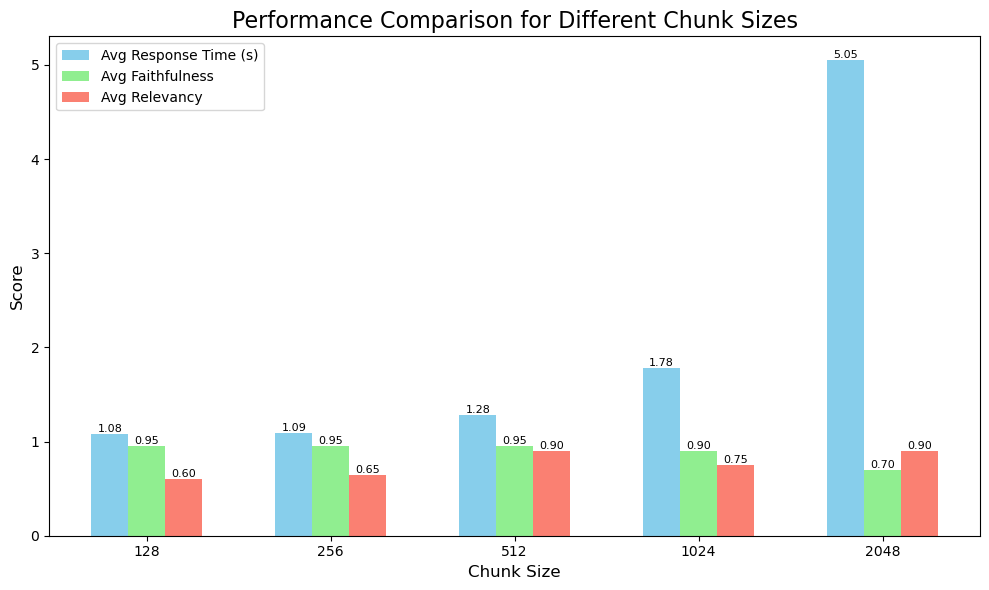

Il grafico aggiornato è stato salvato nella cartella 'immaginiPDF' come 'chunk_size_performance_comparison_updated.pdf'.


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Assicurati che la cartella immaginiPDF esista
if not os.path.exists('immaginiPDF'):
    os.makedirs('immaginiPDF')

# Dati forniti
data = {
    "Chunk Size": [128, 256, 512, 1024, 2048],
    "Average Response Time (s)": [1.08, 1.09, 1.28, 1.78, 5.05],
    "Average Faithfulness": [0.95, 0.95, 0.95, 0.90, 0.70],
    "Average Relevancy": [0.60, 0.65, 0.90, 0.75, 0.90]
}
df = pd.DataFrame(data)

def create_chunk_size_plot():
    plt.figure(figsize=(10, 6))  # Aumentata l'altezza per fare spazio alle annotazioni
    x = np.arange(len(df['Chunk Size']))
    width = 0.2

    # Plotta le barre per ogni metrica
    plt.bar(x - width, df['Average Response Time (s)'], width, label='Avg Response Time (s)', color='skyblue')
    plt.bar(x, df['Average Faithfulness'], width, label='Avg Faithfulness', color='lightgreen')
    plt.bar(x + width, df['Average Relevancy'], width, label='Avg Relevancy', color='salmon')

    plt.xlabel('Chunk Size', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Performance Comparison for Different Chunk Sizes', fontsize=16)
    plt.xticks(x, df['Chunk Size'], fontsize=10)
    plt.legend(fontsize=10)

    # Aggiungi i valori sopra le barre
    for i, metric in enumerate(['Average Response Time (s)', 'Average Faithfulness', 'Average Relevancy']):
        for j, v in enumerate(df[metric]):
            plt.text(j + (i-1)*width, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)


    plt.tight_layout()
    
    # Salva il grafico in PDF
    pdf_path = os.path.join('immaginiPDF', 'chunk_size_performance_comparison_updated.pdf')
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"Grafico salvato come {pdf_path}")
    
    # Visualizza il grafico
    plt.show()

# Crea il grafico
create_chunk_size_plot()
print("Il grafico aggiornato è stato salvato nella cartella 'immaginiPDF' come 'chunk_size_performance_comparison_updated.pdf'.")

## Analisi dei Dati

### Dimensioni dei Chunk

- **Dimensioni più piccole (128, 256)**: Offrono tempi di risposta più rapidi, ma la pertinenza è inferiore rispetto ai chunk size più grandi. La fedeltà rimane alta, ma la pertinenza non è altrettanto buona come con i chunk size maggiori.

- **Dimensioni medie (512)**: Forniscono un buon compromesso con tempi di risposta moderati e la migliore pertinenza. La fedeltà è alta e la pertinenza è molto buona.

- **Dimensioni più grandi (1024, 2048)**: Presentano tempi di risposta più lunghi, ma la pertinenza è molto alta, specialmente per il chunk size di 2048. Tuttavia, la fedeltà diminuisce per i chunk size più grandi.

### Raccomandazione

**Dimensione del Chunk di 512**: Questa dimensione sembra offrire un equilibrio ottimale tra il tempo di risposta e la qualità delle risposte. Fornisce un buon compromesso tra fedeltà e pertinenza senza un tempo di risposta eccessivamente lungo.

**Dimensione del Chunk di 256**: Potrebbe essere una scelta valida se preferisci tempi di risposta leggermente più rapidi, mantenendo una qualità di risposta ancora accettabile.
